In [ ]:
import torch 
import torchvision
from torchvision import transforms as T
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import os

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

#Loading and normalizing the CIFAR100 training and test datasets using torchvision

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

#Loading Traning data
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#Loading Testing data but will not train this
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# data_dir = '/content/data/cifar-100-python'
# print(os.listdir(data_dir))
# classes = os.listdir(data_dir + "/train")
# print(classes[:10])
# print(len(classes))
classes = ('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 
           'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 
           'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
           'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 
           'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 
           'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 
           'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 
           'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')


Files already downloaded and verified
Files already downloaded and verified


#Ploting Traning Images to check dataset is import correctly

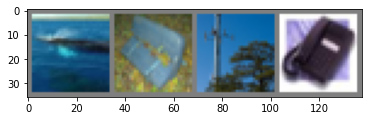

whale couch pine_tree telephone


In [ ]:
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

#Defining MobilenetV2
Bottleneck residual block = 1x1 conv2d- ReLU6, 3x3 dwise s=s - ReLU6, linear 1x1 conv2d

The architecture of MobileNetV2 contains the initial fully convolution layer with 32 ﬁlters, followed by 19 residual bottleneck layers

In [ ]:
class LinearBottleNeck(nn.Module):

    def __init__(self, in_channels, out_channels, stride, t=6, class_num=100):
        super().__init__()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * t, 1),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, in_channels * t, 3, stride=stride, padding=1, groups=in_channels * t),
            nn.BatchNorm2d(in_channels * t),
            nn.ReLU6(inplace=True),

            nn.Conv2d(in_channels * t, out_channels, 1),
            nn.BatchNorm2d(out_channels)
        )

        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

    def forward(self, x):

        residual = self.residual(x)

        if self.stride == 1 and self.in_channels == self.out_channels:
            residual += x

        return residual

class MobileNetV2(nn.Module):

    def __init__(self, class_num=100):
        super().__init__()

        self.pre = nn.Sequential(
            nn.Conv2d(3, 32, 1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU6(inplace=True)
        )

        self.stage1 = LinearBottleNeck(32, 16, 1, 1)
        self.stage2 = self._make_stage(2, 16, 24, 2, 6)
        self.stage3 = self._make_stage(3, 24, 32, 2, 6)
        self.stage4 = self._make_stage(4, 32, 64, 2, 6)
        self.stage5 = self._make_stage(3, 64, 96, 1, 6)
        self.stage6 = self._make_stage(3, 96, 160, 1, 6)
        self.stage7 = LinearBottleNeck(160, 320, 1, 6)

        self.conv1 = nn.Sequential(
            nn.Conv2d(320, 1280, 1),
            nn.BatchNorm2d(1280),
            nn.ReLU6(inplace=True)
        )

        self.conv2 = nn.Conv2d(1280, class_num, 1)

    def forward(self, x):
        x = self.pre(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.conv1(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)

        return x

    def _make_stage(self, repeat, in_channels, out_channels, stride, t):

        layers = []
        layers.append(LinearBottleNeck(in_channels, out_channels, stride, t))

        while repeat - 1:
            layers.append(LinearBottleNeck(out_channels, out_channels, 1, t))
            repeat -= 1

        return nn.Sequential(*layers)
net = MobileNetV2()

#3. Defining a Loss function and optimizer

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 

#Traning network
Here simply we have to loop over our data iterator, and feed the inputs to the network and optimize.

In [ ]:
for epoch in range(2):
  runing_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    runing_loss +=loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, runing_loss/2000))
      runing_loss = 0.0

print('Finished Training')

[1,  2000] loss: 4.599
[1,  4000] loss: 4.373
[1,  6000] loss: 4.224
[1,  8000] loss: 4.076
[1, 10000] loss: 4.000
[1, 12000] loss: 3.908
[2,  2000] loss: 3.777
[2,  4000] loss: 3.712
[2,  6000] loss: 3.669
[2,  8000] loss: 3.619
[2, 10000] loss: 3.557
[2, 12000] loss: 3.501
Finished Training


#Saving a model

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

#Testing the network on the test data

We have trained the network over the training dataset. But we need to check if the network has learnt anything at all. To check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

 Let us display an image from the test set to get familiar.

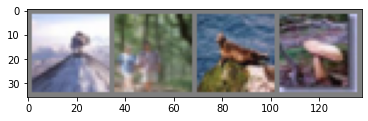

GroundTruth:  mountain forest  seal mushroom


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

#Load back in our saved model

In [ ]:
net = MobileNetV2()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  bridge squirrel sunflower  bowl


#Looking at how the network performs on the whole dataset.

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 17 %


#Overall class accuracy 

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class apple is: 32.0 %
Accuracy for class aquarium_fish is: 9.0 %
Accuracy for class baby  is: 0.0 %
Accuracy for class bear  is: 22.0 %
Accuracy for class beaver is: 1.0 %
Accuracy for class bed   is: 3.0 %
Accuracy for class bee   is: 36.0 %
Accuracy for class beetle is: 3.0 %
Accuracy for class bicycle is: 18.0 %
Accuracy for class bottle is: 29.0 %
Accuracy for class bowl  is: 26.0 %
Accuracy for class boy   is: 2.0 %
Accuracy for class bridge is: 36.0 %
Accuracy for class bus   is: 5.0 %
Accuracy for class butterfly is: 3.0 %
Accuracy for class camel is: 3.0 %
Accuracy for class can   is: 2.0 %
Accuracy for class castle is: 48.0 %
Accuracy for class caterpillar is: 1.0 %
Accuracy for class cattle is: 5.0 %
Accuracy for class chair is: 51.0 %
Accuracy for class chimpanzee is: 8.0 %
Accuracy for class clock is: 5.0 %
Accuracy for class cloud is: 39.0 %
Accuracy for class cockroach is: 13.0 %
Accuracy for class couch is: 12.0 %
Accuracy for class crab  is: 0.0 %
Accuracy

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar

https://github.com/weiaicunzai/pytorch-cifar100